In [1]:
%load_ext autoreload
%autoreload 2


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }<\style>"))
import argparse
import os
import pandas as pd

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from PIL import Image
import tqdm


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from collections import OrderedDict
from torch.nn.functional import one_hot as one_hot
import torch.utils.data as data
import utils
from model import * 


In [4]:
def get_negative_mask(batch_size):
    negative_mask = torch.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0

    negative_mask = torch.cat((negative_mask, negative_mask), 0)
    return negative_mask

def triplet(out_1,out_2,tau_plus,batch_size,temperature, debias = True):
    N = batch_size * 2 - 2
    out = torch.cat([out_1, out_2], dim=0) # 2 * bs x fs
    s = torch.pow(out.unsqueeze(0) - out.unsqueeze(1), 2).sum(-1) # 2 * bs x 2 * bs
    mask = get_negative_mask(batch_size).to(device)
    
    if debias:
        s = s.masked_select(mask).view(2 * batch_size, -1)  # (2 * bs, 2 * bs - 2) : subtract self and its augment

        pos = (torch.pow(out_1 - out_2, 2))
        pos = torch.cat([pos, pos], dim=0).sum(-1)

        neg = (-tau_plus * N * pos + s.sum(-1)) / (1 - tau_plus)

    else:
        neg = s.masked_select(mask).view(2 * batch_size, -1)  # (2 * bs, 2 * bs - 2) : subtract self and its augment

        pos = (torch.pow(out_1 - out_2, 2))
        pos = torch.cat([pos, pos], dim=0).sum(-1)

    return (pos - neg).mean()

def W(out_d, out_b, batch_size):
    mask = get_negative_mask(batch_size).to(device)
    
#     difficulty by cosine similarity
    s_d = torch.exp(torch.mm(out_d, out_d.t().contiguous()) / temperature)
    s_d = s_d.masked_select(mask).view(2 * batch_size, -1) # (2 * bs, 2 * bs - 2) : subtract self and its augment
    s_d = F.normalize(s_d, dim = -1)
    
    s_b = torch.exp(torch.mm(out_b, out_b.t().contiguous()) / temperature)
    s_b = s_b.masked_select(mask).view(2 * batch_size, -1) # (2 * bs, 2 * bs - 2) : subtract self and its augment
    s_b = F.normalize(s_b, dim = -1)
    
    weight = 1 + s_d / (s_b + s_d + 1e-6)
#     print(weight)
    if np.isnan(weight.sum().item()):
        print('weight NaN')
        
    return weight.detach()

def criterion(out_1_d, out_2_d, out_1_b, out_2_b, tau_plus, batch_size, beta, temperature):
    # neg score
    out = torch.cat([out_1_d, out_2_d], dim=0)
    out_b = torch.cat([out_1_b, out_2_b], dim=0)
    neg = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
    mask = get_negative_mask(batch_size).to(device)
    neg = neg.masked_select(mask).view(2 * batch_size, -1) # (2 * bs, bs - 2) : subtract self and its augment

    # pos score
    pos = torch.exp(torch.sum(out_1_d * out_2_d, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)
    
    weight = W(out, out_b, batch_size) # (2 * bs, bs - 2)

    # negative samples similarity scoring
    N = batch_size * 2 - 2
#         imp = (beta* neg.log()).exp()
#         reweight_neg = (imp*neg).sum(dim = -1) / imp.mean(dim = -1)
    reweight_neg = weight * neg

    Ng = (-tau_plus * N * pos + reweight_neg.sum(dim = -1)) / (1 - tau_plus)
    # constrain (optional)
    Ng = torch.clamp(Ng, min = N * np.e**(-1 / temperature))

    # contrastive loss
    loss = (-torch.log(pos / (pos + Ng) )).mean()

    return loss

In [12]:
model_d = Image_Model().cuda()
model_d = nn.DataParallel(model_d)
model_d.load_state_dict(torch.load(os.path.join("../results", dataset_name, 'wcl', 'no_orient_new/cub_model_d_256_0.1_0.3_0.001_100.pth')))
model_d.eval()

model_b = Image_Model().cuda()
model_b = nn.DataParallel(model_b)
model_b.load_state_dict(torch.load(os.path.join("../results", dataset_name, 'wcl', 'no_orient_new/cub_model_b_256_0.1_0.3_0.001_100.pth')))
model_b.eval()


DataParallel(
  (module): Image_Model(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Bat

In [7]:
batch_size = 128
device = 'cuda:0'
tau_plus = 0.1
dataset_name = 'cub'
beta =0.9
estimator = 'hard'
temperature =0.7
epochs = 400



In [8]:
train_data, memory_data, test_data = utils.get_dataset('cub', root='../data')

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True, drop_last=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

k = 200
c = len(memory_data.classes)

In [9]:
x_1, x_2, s, y = iter(test_loader).next()

x_1, x_2, s, y = x_1.cuda(), x_2.cuda(), s.cuda(), y.cuda() 

In [13]:
with torch.no_grad():
    feature_1, out_1_d = model_d(x_1)
    feature_2, out_2_d = model_d(x_2)

    feature_1, out_1_b = model_b(x_1)
    feature_2, out_2_b = model_b(x_2)

    #         loss_tri = triplet(out_1_b, out_2_b, batch_size)
    #         loss_ori = orientation(out_1_d, out_2_d, out_1_b, out_2_b, batch_size)
    out = torch.cat([out_1_d, out_2_d], dim=0)
    out_b = torch.cat([out_1_b, out_2_b], dim=0)
    neg = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
    mask = get_negative_mask(batch_size).to(device)
    neg = neg.masked_select(mask).view(2 * batch_size, -1) # (2 * bs, bs - 2) : subtract self and its augment

    # pos score
    pos = torch.exp(torch.sum(out_1_d * out_2_d, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)

    weight = W(out, out_b, batch_size) # (2 * bs, bs - 2)    

    

In [14]:
mean = torch.tensor([0.485, 0.456, 0.406]).cuda().view(1, -1, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).cuda().view(1, -1, 1, 1)

tensor(1, device='cuda:0') tensor(1, device='cuda:0')


Text(0.5, 1.0, 'Anchor')

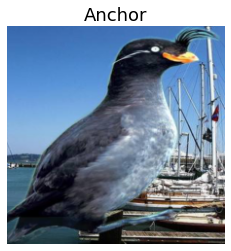

In [60]:
img_idx = 30
plt.imshow(  (x_1 * std + mean)[img_idx].permute(1, 2, 0).cpu().detach().numpy()  )

print(s[img_idx], y[img_idx])
plt.axis('off')
plt.title("Anchor", fontsize = 18)

In [ ]:
label = 0 landbird on land
label = 1 landbird on water
label = 2 waterbird on land
label = 3 waterbird on water

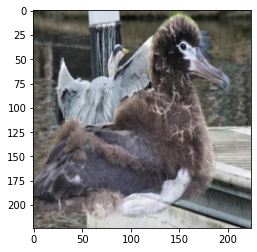

tensor(1, device='cuda:0')


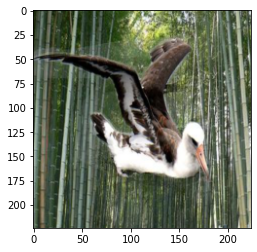

tensor(1, device='cuda:0')


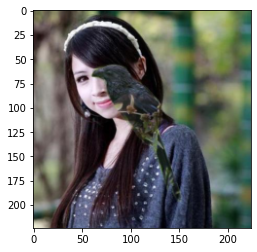

tensor(0, device='cuda:0')


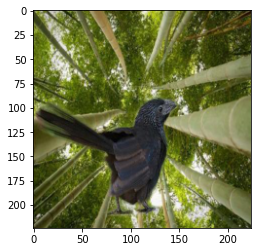

tensor(0, device='cuda:0')


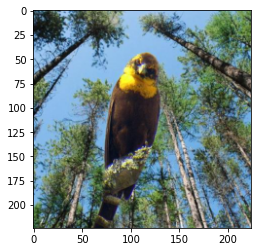

tensor(0, device='cuda:0')
[3, 2, 0, 0, 0]


In [61]:
sort_idx = weight[img_idx].argsort()

sort_idx[sort_idx < 254/2] = sort_idx[sort_idx < 254/2] + 1
sort_idx[sort_idx >= 254/2] = sort_idx[sort_idx >= 254/2] + 2
sort_idx[sort_idx >= 128] -= 128

included  = list()
labels = []
easy_images = []
cnt =1
for i in sort_idx:
    if cnt > 5:
        break
    if i not in included:
        included.append(i)

        if i < 128:
            plt.imshow(  (x_1 * std + mean)[i].permute(1, 2, 0).cpu().detach().numpy())
            easy_images.append((x_1 * std + mean)[i].permute(1, 2, 0).cpu().detach().numpy())
        else:
            i = i - 128
            plt.imshow(  (x_2 * std + mean)[i].permute(1, 2, 0).cpu().detach().numpy())
            easy_images.append((x_2 * std + mean)[i].permute(1, 2, 0).cpu().detach().numpy())
        plt.show()
        print(y[i])
        cnt += 1
        labels.append((s[i] + 2 * y[i]).item())

    else:
        pass
    
    
print(labels)

In [ ]:
3 x landbird on land on easy negative

In [ ]:
label = 0 landbird on land
label = 1 landbird on water
label = 2 waterbird on land
label = 3 waterbird on water

Text(0.5, 1.0, 'Easy Negatives')

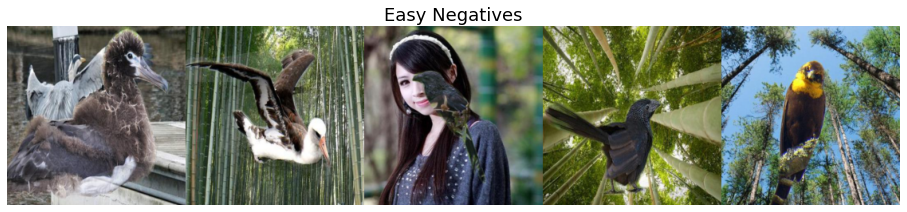

In [62]:
plt.figure(figsize = (16,4))
plt.imshow(np.hstack(easy_images))
plt.xticks([i for i in range(6)])
plt.axis('off')
plt.xticks([0, 1, 2, 4,5], ['January', 'February', 'March', 'February', 'March'])
plt.title("Easy Negatives", fontsize = 18)

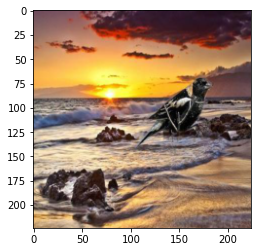

tensor(0, device='cuda:0')


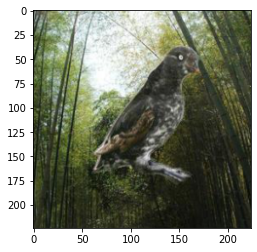

tensor(1, device='cuda:0')


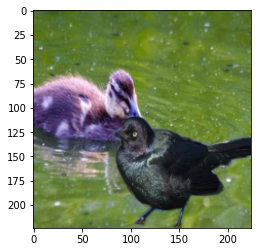

tensor(0, device='cuda:0')


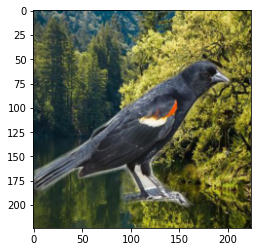

tensor(0, device='cuda:0')


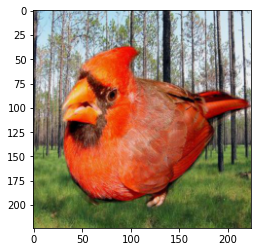

tensor(0, device='cuda:0')
[1, 2, 1, 0, 0]


In [63]:
sort_idx = (-weight[img_idx]).argsort()

sort_idx[sort_idx < 254/2] = sort_idx[sort_idx < 254/2] + 1
sort_idx[sort_idx >= 254/2] = sort_idx[sort_idx >= 254/2] + 2
sort_idx[sort_idx >= 128] -= 128

included  = list()
labels = []
hard_images = []
cnt = 1
for i in sort_idx:
    if cnt > 5:
        break
    if i not in included:
        included.append(i)

        if i < 128:
            plt.imshow(  (x_1 * std + mean)[i].permute(1, 2, 0).cpu().detach().numpy())
            hard_images.append((x_1 * std + mean)[i].permute(1, 2, 0).cpu().detach().numpy())
        else:
            i = i - 128
            plt.imshow(  (x_2 * std + mean)[i].permute(1, 2, 0).cpu().detach().numpy())
            hard_images.append((x_2 * std + mean)[i].permute(1, 2, 0).cpu().detach().numpy())
        plt.show()
        print(y[i])
        cnt += 1
        labels.append((s[i] + 2 * y[i]).item())
    else:
        pass
    
print(labels)

In [ ]:
2 x landbird on water


label = 0 landbird on land
label = 1 landbird on water
label = 2 waterbird on land
label = 3 waterbird on water

Text(0.5, 1.0, 'Hard Negatives')

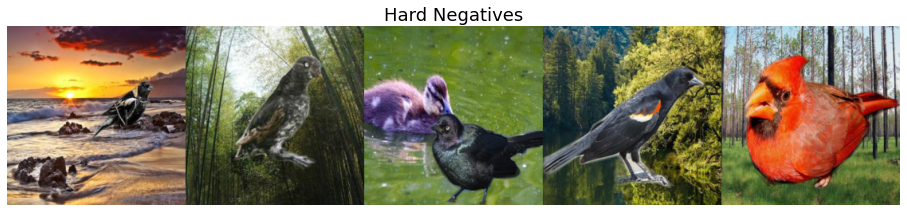

In [65]:
plt.figure(figsize = (16,4))
plt.imshow(np.hstack(hard_images))
plt.xticks([i for i in range(6)])
plt.axis('off')
plt.xticks([0, 1, 2, 4,5], ['January', 'February', 'March', 'February', 'March'])
plt.title("Hard Negatives", fontsize = 18)

In [55]:
water bird on water (3)

Easy: 
land bird on land (0)
Hard:
# land bird on water (1) or 
land bird on water (1)

SyntaxError: invalid syntax (2676139350.py, line 1)

In [16]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        base = models.resnet18(pretrained=True)
        base.fc = nn.Linear(512, 512)
        
        self.model = base
        self.finalLayer = nn.Linear(512, 256)
            
    def forward(self, x, sens = None):
        feature = self.model(x)
        output = self.finalLayer(torch.relu(feature))
            
        return F.normalize(feature, dim = -1), F.normalize(output, dim = -1)

In [5]:
model_d = Classifier().cuda()
model_d = nn.DataParallel(model_d)

model_b = Classifier().cuda()
model_b = nn.DataParallel(model_b)

optimizer_d = optim.Adam(model_d.parameters(), lr=5e-4, weight_decay=1e-6)
optimizer_b = optim.Adam(model_b.parameters(), lr=1e-3, weight_decay=1e-6)

In [6]:
batch_size = 256
device = 'cuda:0'
tau_plus = 0.2
dataset_name = 'cub'
beta =0.9
estimator = 'hard'
temperature =0.7
epochs = 400



In [7]:
train_data, memory_data, test_data = utils.get_dataset('cub', root='../data')

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True, drop_last=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

k = 200
c = len(memory_data.classes)

In [19]:
for tau_plus in [0.1, 0.2, 0.5]:
    for temperature in [0.1, 0.5, 1]:
        print(tau_plus, temperature)
        
        model_d = Classifier().cuda()
        model_d = nn.DataParallel(model_d)

        model_b = Classifier().cuda()
        model_b = nn.DataParallel(model_b)

        optimizer_d = optim.Adam(model_d.parameters(), lr=1e-4, weight_decay=1e-6)
        optimizer_b = optim.Adam(model_b.parameters(), lr=1e-4, weight_decay=1e-6)        
        
        
        for epoch in range(2 + 1):
            model_d.train()

            total_loss, total_num, train_bar = 0.0, 0, tqdm.tqdm(train_loader)
            total_loss_tri = 0
            total_loss_ori = 0
            total_loss_crt = 0


            for pos_1, pos_2, sens, target in train_bar:
                pos_1, pos_2 = pos_1.to(device,non_blocking=True), pos_2.to(device,non_blocking=True)

                feature_1, out_1_d = model_d(pos_1)
                feature_2, out_2_d = model_d(pos_2)

                feature_1, out_1_b = model_b(pos_1)
                feature_2, out_2_b = model_b(pos_2)

                loss_tri = triplet(out_1_b, out_2_b, tau_plus, batch_size, temperature)
                loss_ori = orientation(out_1_d, out_2_d, out_1_b, out_2_b, batch_size)
                loss_crt = criterion(out_1_d, out_2_d, out_1_b, out_2_b, tau_plus, batch_size, beta, temperature)
                if np.isnan(loss_tri.item()):
            #         torch.save(net_d.state_dict(), '../results_wctr/{}/{}_{}_model_d_{}_{}_{}_{}_ERROR.pth'.format(dataset_name,dataset_name,estimator,batch_size,tau_plus,beta,epoch))
            #         torch.save(net_b.state_dict(), '../results_wctr/{}/{}_{}_model_b_{}_{}_{}_{}_ERROR.pth'.format(dataset_name,dataset_name,estimator,batch_size,tau_plus,beta,epoch))
                    raise NameError('loss_tri')

                if np.isnan(loss_ori.item()):
            #         torch.save(net_d.state_dict(), '../results_wctr/{}/{}_{}_model_d_{}_{}_{}_{}_ERROR.pth'.format(dataset_name,dataset_name,estimator,batch_size,tau_plus,beta,epoch))
            #         torch.save(net_b.state_dict(), '../results_wctr/{}/{}_{}_model_b_{}_{}_{}_{}_ERROR.pth'.format(dataset_name,dataset_name,estimator,batch_size,tau_plus,beta,epoch))           
                    raise NameError('loss_ori')

                if np.isnan(loss_crt.item()):
            #         torch.save(net_d.state_dict(), '../results_wctr/{}/{}_{}_model_d_{}_{}_{}_{}_ERROR.pth'.format(dataset_name,dataset_name,estimator,batch_size,tau_plus,beta,epoch))
            #         torch.save(net_b.state_dict(), '../results_wctr/{}/{}_{}_model_b_{}_{}_{}_{}_ERROR.pth'.format(dataset_name,dataset_name,estimator,batch_size,tau_plus,beta,epoch))           
                    raise NameError('loss_crt')

                loss = loss_tri + loss_crt

                optimizer_b.zero_grad()
                optimizer_d.zero_grad()
                loss.backward()
                optimizer_b.step()
                optimizer_d.step()

                total_num += batch_size
                total_loss_tri += loss_tri.item() * batch_size
                total_loss_ori += loss_ori.item() * batch_size
                total_loss_crt += loss_crt.item() * batch_size

                train_bar.set_description('Train Epoch: [{}/{}] loss_tri : {:.4f}, loss_ori : {:.4f}, loss_crt: {:.4f}'\
                          .format(epoch, epochs, total_loss_tri / total_num, total_loss_ori / total_num, total_loss_crt / total_num))


        model_d.eval()
        total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
        with torch.no_grad():
            # generate feature bank

            if dataset_name in ['celeba', 'cub']:
                feature_labels = []
                for data, _, sens, target in tqdm. tqdm(memory_loader, desc='Feature extracting'):
                    feature, out = model_d(data.to(device, non_blocking=True))
                    feature_bank.append(feature)
                    feature_labels.extend(target * 2 + sens)

                    total_correct = np.array([0] * c)
                    total_num_class = np.array([0] * c)

            else:
                for data, _, sens, target in tqdm. tqdm(memory_loader, desc='Feature extracting'):
                    feature, out = model_d(data.to(device, non_blocking=True))
                    feature_bank.append(feature)

            # [D, N]
            feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
            # [N]
            if 'cifar' in dataset_name:
                feature_labels = torch.tensor(memory_loader.dataset.targets, device=feature_bank.device) 
            elif 'stl' in dataset_name:
                feature_labels = torch.tensor(memory_loader.dataset.labels, device=feature_bank.device) 
            elif dataset_name in ['celeba', 'cub']:
                feature_labels = torch.tensor(feature_labels, device=feature_bank.device) 

            # loop test data to predict the label by weighted knn search
            test_bar = tqdm. tqdm(test_loader)


            for data, _, sens, target in test_bar:
                data, sens, target = data.to(device, non_blocking=True), sens.to(device, non_blocking=True), target.to(device, non_blocking=True)

                group = abs(target) * 2 + abs(sens)

                feature, out = model_d(data)

                total_num += data.size(0)

                for i in range(c):
                    total_num_class[i] += torch.sum((group == i).float()).item()

                # compute cos similarity between each feature vector and feature bank ---> [B, N]
                sim_matrix = torch.mm(feature, feature_bank)
                # [B, K]
                sim_weight, sim_indices = sim_matrix.topk(k=k, dim=-1)
                # [B, K]
                sim_labels = torch.gather(feature_labels.expand(data.size(0), -1), dim=-1, index=sim_indices)
                sim_weight = (sim_weight / temperature).exp()

                # [B*K, C]
                one_hot_label = F.one_hot(sim_labels.view(-1, 1).long(), c)
                # weighted score ---> [B, C]
                pred_scores = torch.sum(one_hot_label.view(data.size(0), -1, c) * sim_weight.unsqueeze(dim=-1), dim=1)

                pred_labels = pred_scores.argsort(dim=-1, descending=True)
                total_top1 += torch.sum((pred_labels[:,:1] == target.long().unsqueeze(dim=-1)).any(dim=-1).float()).item()

                for i in range(c):
                    total_correct[i] += torch.sum((pred_labels[group == i,:1] == target[group == i].long().unsqueeze(dim=-1)).any(dim=-1).float()).item()

                desc = 'KNN Test Epoch: [{}/{}] Acc :{:.2f}%, '\
                            .format(epoch, epochs, total_top1 / total_num * 100)

                for i in range(c):
                    desc += 'group {} acc : {:.2f}%, '.format(i, (total_correct[i] / total_num_class[i]) * 100)

                test_bar.set_description(desc)

                #logger_train.info(desc)



0.1 0.1


Train Epoch: [0/400] loss_tri : -922.5251, loss_ori : -0.0601, loss_crt: 0.2289: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.40it/s]
Train Epoch: [1/400] loss_tri : -1117.8494, loss_ori : -0.0438, loss_crt: 0.0009: 100%|████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.41it/s]
Train Epoch: [2/400] loss_tri : -1129.2675, loss_ori : -0.1028, loss_crt: 0.0007: 100%|████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.41it/s]
Feature extracting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.20it/s]
KNN Test Epoch: [2/400] Acc :47.54%, group 0 acc : 98.29%, group 1 acc : 23.82%, group 2 acc : 0.00%, group 3 acc : 0.00%, : 100%|███████████████████| 5/5 [00:03<00:00,  1.60it/s]


0.1 0.5


Train Epoch: [0/400] loss_tri : -909.3126, loss_ori : -0.0184, loss_crt: 5.0241: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.39it/s]
Train Epoch: [1/400] loss_tri : -1116.8221, loss_ori : -0.0572, loss_crt: 4.5391: 100%|████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.39it/s]
Train Epoch: [2/400] loss_tri : -1128.9351, loss_ori : -0.0569, loss_crt: 4.4710: 100%|████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.38it/s]
Feature extracting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.01it/s]
KNN Test Epoch: [2/400] Acc :46.37%, group 0 acc : 97.43%, group 1 acc : 21.67%, group 2 acc : 0.00%, group 3 acc : 0.00%, : 100%|███████████████████| 5/5 [00:02<00:00,  1.67it/s]


0.1 1


Train Epoch: [0/400] loss_tri : -921.1953, loss_ori : 0.0260, loss_crt: 5.8810: 100%|██████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.33it/s]
Train Epoch: [1/400] loss_tri : -1117.5981, loss_ori : 0.0283, loss_crt: 5.6667: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.32it/s]
Train Epoch: [2/400] loss_tri : -1128.6265, loss_ori : 0.0261, loss_crt: 5.6417: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.38it/s]
Feature extracting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.01it/s]
KNN Test Epoch: [2/400] Acc :48.37%, group 0 acc : 97.64%, group 1 acc : 26.61%, group 2 acc : 0.00%, group 3 acc : 0.00%, : 100%|███████████████████| 5/5 [00:02<00:00,  1.71it/s]


0.2 0.1


Train Epoch: [0/400] loss_tri : -962.0718, loss_ori : -0.1915, loss_crt: 0.0618: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.37it/s]
Train Epoch: [1/400] loss_tri : -1246.7977, loss_ori : -0.0032, loss_crt: 0.0000: 100%|████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.36it/s]
Train Epoch: [2/400] loss_tri : -1265.2532, loss_ori : -0.0621, loss_crt: 0.0000: 100%|████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.41it/s]
Feature extracting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.21it/s]
KNN Test Epoch: [2/400] Acc :49.71%, group 0 acc : 98.93%, group 1 acc : 28.76%, group 2 acc : 0.00%, group 3 acc : 0.00%, : 100%|███████████████████| 5/5 [00:02<00:00,  1.81it/s]


0.2 0.5


Train Epoch: [0/400] loss_tri : -1007.3999, loss_ori : -0.0319, loss_crt: 4.6143: 100%|████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.36it/s]
Train Epoch: [1/400] loss_tri : -1251.9195, loss_ori : -0.0092, loss_crt: 3.6209: 100%|████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.42it/s]
Train Epoch: [2/400] loss_tri : -1267.2474, loss_ori : -0.0108, loss_crt: 3.4624: 100%|████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.39it/s]
Feature extracting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.15it/s]
KNN Test Epoch: [2/400] Acc :45.20%, group 0 acc : 97.43%, group 1 acc : 18.67%, group 2 acc : 0.00%, group 3 acc : 0.00%, : 100%|███████████████████| 5/5 [00:03<00:00,  1.65it/s]


0.2 1


Train Epoch: [0/400] loss_tri : -1009.0405, loss_ori : -0.0142, loss_crt: 5.8312: 100%|████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.39it/s]
Train Epoch: [1/400] loss_tri : -1252.1590, loss_ori : 0.0124, loss_crt: 5.5669: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.34it/s]
Train Epoch: [2/400] loss_tri : -1267.6188, loss_ori : 0.0135, loss_crt: 5.5396: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.37it/s]
Feature extracting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.30it/s]
KNN Test Epoch: [2/400] Acc :46.04%, group 0 acc : 98.29%, group 1 acc : 19.96%, group 2 acc : 0.00%, group 3 acc : 0.00%, : 100%|███████████████████| 5/5 [00:03<00:00,  1.67it/s]


0.5 0.1


Train Epoch: [0/400] loss_tri : -1561.0822, loss_ori : 0.1626, loss_crt: 0.0029: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.52it/s]
Train Epoch: [1/400] loss_tri : -1979.5121, loss_ori : 0.0388, loss_crt: 0.0000: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.35it/s]
Train Epoch: [2/400] loss_tri : -2012.9848, loss_ori : 0.0497, loss_crt: 0.0000: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.33it/s]
Feature extracting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.07it/s]
KNN Test Epoch: [2/400] Acc :48.29%, group 0 acc : 97.86%, group 1 acc : 26.18%, group 2 acc : 0.00%, group 3 acc : 0.00%, : 100%|███████████████████| 5/5 [00:03<00:00,  1.58it/s]


0.5 0.5


Train Epoch: [0/400] loss_tri : -1601.3955, loss_ori : 0.0284, loss_crt: 3.2589: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.40it/s]
Train Epoch: [1/400] loss_tri : -1983.5000, loss_ori : 0.0335, loss_crt: 2.4459: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.41it/s]
Train Epoch: [2/400] loss_tri : -2013.6987, loss_ori : 0.0317, loss_crt: 2.4115: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.38it/s]
Feature extracting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.08it/s]
KNN Test Epoch: [2/400] Acc :43.62%, group 0 acc : 95.29%, group 1 acc : 16.74%, group 2 acc : 0.00%, group 3 acc : 0.00%, : 100%|███████████████████| 5/5 [00:02<00:00,  1.71it/s]


0.5 1


Train Epoch: [0/400] loss_tri : -1546.3291, loss_ori : 0.0155, loss_crt: 5.4252: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.37it/s]
Train Epoch: [1/400] loss_tri : -1979.1570, loss_ori : 0.0158, loss_crt: 4.6940: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.41it/s]
Train Epoch: [2/400] loss_tri : -2013.9585, loss_ori : 0.0167, loss_crt: 4.6054: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.40it/s]
Feature extracting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.65it/s]
KNN Test Epoch: [2/400] Acc :47.12%, group 0 acc : 98.29%, group 1 acc : 22.75%, group 2 acc : 0.00%, group 3 acc : 0.00%, : 100%|███████████████████| 5/5 [00:03<00:00,  1.62it/s]


## Sanity check

In [5]:
batch_size = 256
lr = 1e-3
device = 'cuda:0'
tau_plus = 0.2

epochs = 300

In [6]:
train_data, memory_data, test_data = utils.get_dataset('cub', root='../data', pair = False)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True, drop_last=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)


In [8]:
baseline = Classifier()
baseline = nn.DataParallel(baseline)

baseline.load_state_dict(torch.load(os.path.join("../results", 'cub', 'wcl','no_orient_new', 'cub_model_d_256_0.2_0.001_500.pth')))
baseline.module.finalLayer = nn.Linear(512, 2)
baseline = baseline.cuda()


In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
optimizer = optim.SGD(baseline.module.finalLayer.parameters(), lr = 1e-3, weight_decay = 1e-4, momentum = 0.9)

In [11]:
class Classifier(nn.Module):
    def __init__(self, model_name = 'res50'):
        super(Classifier, self).__init__()
        
        self.model_name = model_name
        
        if model_name == 'res50':
            base = models.resnet50(pretrained=True)
#             for param in base.parameters():
#                 param.requires_grad = False
            
            base.fc = nn.Linear(2048, 2)
            base.fc.weight.requires_grad = True
            base.fc.bias.requires_grad = True
            
            self.model = base
#             self.conv1 = base.conv1
#             self.bn1 = base.bn1
#             self.relu = base.relu
#             self.maxpool = base.maxpool

#             self.layer1 = base.layer1
#             self.layer2 = base.layer2
#             self.layer3 = base.layer3
#             self.layer4 = base.layer4

#             self.avgpool = base.avgpool

        
        elif model_name == 'res18':
            base = models.resnet18(pretrained=True)
            
            self.conv1 = base.conv1
            self.bn1 = base.bn1
            self.relu = base.relu
            self.maxpool = base.maxpool

            self.layer1 = base.layer1
            self.layer2 = base.layer2
            self.layer3 = base.layer3
            self.layer4 = base.layer4

            self.avgpool = base.avgpool
    #         self.fc1 = nn.Linear(2049, 1024)
            self.fc1 = nn.Linear(512, 512)
            self.finalLayer = nn.Linear(512, 2)
            
        elif model_name == 'vgg19':
            base = models.vgg19(pretrained=True)
            base.classifier[-1] = nn.Sequential(
                      nn.Linear(4096, 1024), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(1024, 1024),                   
                      )
            
            self.vgg = base
            self.finalLayer = nn.Linear(in_features=1024, out_features=2)
            
        elif model_name == 'vgg16':
            base = models.vgg16(pretrained=True)
            base.classifier[-1] = nn.Sequential(
                      nn.Linear(4096, 1024), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(1024, 1024),                   
                      )
            
            self.vgg = base
            self.finalLayer = nn.Linear(in_features=1024, out_features=2)    
            
    def forward(self, x, sens = None):
#         sens = sens.view(-1,1)
        if 'res' in self.model_name:
#             x = self.conv1(x)
#             x = self.bn1(x)
#             x = self.relu(x)
#             x = self.maxpool(x)
#             x = self.layer1(x)
#             x = self.layer2(x)
#             x = self.layer3(x)
#             x = self.layer4(x)

#             x = self.avgpool(x)

#             if '50' in self.model_name:
#                 x = x.view(-1,2048)
#             elif '18' in self.model_name:
#                 x = x.view(-1,512)
                
#             x = self.fc1(x)
#             output = self.finalLayer(x)
            output = self.model(x)
            
        else:
            x = self.vgg(x)
            output = torch.relu(x)
            output = self.finalLayer(output)
        
        return x, output

In [22]:

# baseline = models.resnet50(pretrained=True)
# baseline.fc = nn.Linear(2048, 2)


baseline = models.resnet18(pretrained=True)
baseline.fc = nn.Linear(512, 2)
baseline = nn.DataParallel(baseline).cuda()

optimizer = optim.SGD(baseline.parameters(), lr = 1e-3, weight_decay=1e-4, momentum = 0.9)

In [12]:
baseline = Classifier('res50').cuda()
baseline = nn.DataParallel(baseline)
optimizer = optim.SGD(baseline.parameters(), lr = 1e-3, weight_decay = 1e-4, momentum = 0.9)

In [11]:
for epoch in range(epochs + 1):
    baseline.train()

    total_loss, total_num, train_bar = 0.0, 0, tqdm.tqdm(train_loader)
    total_loss_tri = 0
    total_loss_ori = 0
    total_loss_crt = 0


    for pos_1, sens, target in train_bar:
        pos_1 = pos_1.to(device,non_blocking=True)
        target = target.to(device)

        feature_1 = baseline(pos_1)
        loss_crt = criterion(feature_1, target)

        loss = loss_crt

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_num += batch_size
        total_loss_crt += loss_crt.item() * batch_size

        train_bar.set_description('Train Epoch: [{}/{}], loss_crt: {:.4f}'\
                  .format(epoch, epochs, total_loss_crt / total_num))
        
    if epoch % 5 == 0:
        baseline.eval()
        total_loss, total_correct, total_num, data_bar = 0.0, 0.0, 0, tqdm.tqdm(test_loader)

        sens_lst, pred_lst, y_lst = [], [], []
        
        with torch.no_grad():
            for data, sens, target in data_bar:
                data, sens, target = data.to(device,non_blocking=True), sens.to(device,non_blocking=True), target.to(device,non_blocking=True)
                out = baseline(data)
                out = out.argmax(-1)
                
                
                sens_lst.append(sens)                
                pred_lst.append(out)
                y_lst.append(target)
                
            sens_lst = torch.cat(sens_lst, 0)
            pred_lst = torch.cat(pred_lst, 0)
            y_lst = torch.cat(y_lst, 0)
            
            
        print('Overall Acc: {:.3f}\n'.format((y_lst == pred_lst).float().mean()))
        group_lst = sens_lst + 2 * y_lst

        for i in range(4):
            idx = group_lst == i
            print('Group {} Acc: {:.3f}'.format(i, (y_lst[idx] == pred_lst[idx]).float().mean()))

  0%|                                                                                                                                                       | 0/18 [00:19<?, ?it/s]


RuntimeError: Caught RuntimeError in replica 1 on device 1.
Original Traceback (most recent call last):
  File "/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/tmp/ipykernel_7096/1614631009.py", line 12, in forward
    feature = self.model(x)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/torchvision/models/resnet.py", line 249, in forward
    return self._forward_impl(x)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/torchvision/models/resnet.py", line 235, in _forward_impl
    x = self.maxpool(x)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/torch/nn/modules/pooling.py", line 162, in forward
    return F.max_pool2d(input, self.kernel_size, self.stride,
  File "/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/torch/_jit_internal.py", line 422, in fn
    return if_false(*args, **kwargs)
  File "/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/torch/nn/functional.py", line 719, in _max_pool2d
    return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 1; 23.70 GiB total capacity; 473.16 MiB already allocated; 26.81 MiB free; 478.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [33]:
#Baseline

        baseline.eval()
        total_loss, total_correct, total_num, data_bar = 0.0, 0.0, 0, tqdm.tqdm(test_loader)

        sens_lst, pred_lst, y_lst = [], [], []
        
        with torch.no_grad():
            for data, sens, target in data_bar:
                data, sens, target = data.to(device,non_blocking=True), sens.to(device,non_blocking=True), target.to(device,non_blocking=True)
                out = baseline(data)
                out = out.argmax(-1)
                
                
                sens_lst.append(sens)                
                pred_lst.append(out)
                y_lst.append(target)
                
            sens_lst = torch.cat(sens_lst, 0)
            pred_lst = torch.cat(pred_lst, 0)
            y_lst = torch.cat(y_lst, 0)
            
            
        print('Overall Acc: {:.3f}\n'.format((y_lst == pred_lst).float().mean()))
        group_lst = sens_lst + 2 * y_lst

        for i in range(4):
            idx = group_lst == i
            print('Group {} Acc: {:.3f}'.format(i, (y_lst[idx] == pred_lst[idx]).float().mean()))

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]

Overall Acc: 0.820

Group 0 Acc: 0.985
Group 1 Acc: 0.800
Group 2 Acc: 0.338
Group 3 Acc: 0.789


In [34]:
is_train = False
num_class = len(test_loader.dataset.classes)
num_sens = len(test_loader.dataset.sens_groups)
num_group = num_sens * num_class

total_loss, total_correct, total_num, data_bar = 0.0, 0.0, 0, tqdm.tqdm(test_loader)
total_correct_min = np.array([0] * num_group)
total_num_class = np.array([0] * num_group)

with (torch.enable_grad() if is_train else torch.no_grad()):
    for data, sens, target in data_bar:
        data, sens, target = data.to(device,non_blocking=True), sens.to(device,non_blocking=True), target.to(device,non_blocking=True)
        out = baseline(data)
        loss = criterion(out, target)

        if is_train:
            train_optimizer.zero_grad()
            loss.backward()
            train_optimizer.step()

        total_num += data.size(0)
        total_loss += loss.item() * data.size(0)
        out = out.argmax(-1)
        total_correct += torch.sum((out == target).float()).item()

        group = target * 2 + sens

        for i in range(num_group):
            idx = group == i
            total_correct_min[i] += torch.sum((out[idx] == target[idx]).float()).item()
            total_num_class[i] += sum(idx).item()

        desc = '{} Epoch: [{}/{}] ACC: {:.2f}% ||'\
                     .format('Train' if is_train else 'Test', epoch, epochs, 
                     total_correct / total_num * 100)

        for i in range(num_group):
            desc += 'group {} acc : {:.2f}%, '.format(i, (total_correct_min[i] / total_num_class[i]) * 100)

        data_bar.set_description(desc)


Test Epoch: [6/300] ACC: 81.98% ||group 0 acc : 98.50%, group 1 acc : 80.04%, group 2 acc : 33.83%, group 3 acc : 78.95%


In [18]:
def get_negative_mask(batch_size):
    negative_mask = torch.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0

    negative_mask = torch.cat((negative_mask, negative_mask), 0)
    return negative_mask

# def triplet(out_1,out_2,batch_size):
#     #biased representation learning
#     out = torch.cat([out_1, out_2], dim=0) # 2 * bs x fs
#     s = (torch.pow(out.unsqueeze(0) - out.unsqueeze(1), 2) / temperature).sum(-1)
    
#     mask = get_negative_mask(batch_size).to(device)
#     s = s.masked_select(mask).view(2 * batch_size, -1)  # (2 * bs, bs - 2) : subtract self and its augment

#     pos = (torch.pow(out_1 - out_2, 2)  / temperature).sum(-1)
#     neg = s.sum(-1)

# #     return torch.clamp(pos - neg + 5, min = 0)
#     return pos.mean() - neg.mean()

def triplet(out_1,out_2,tau_plus,batch_size,temperature, debias = True):
    N = batch_size * 2 - 2
    out = torch.cat([out_1, out_2], dim=0) # 2 * bs x fs
    s = torch.pow(out.unsqueeze(0) - out.unsqueeze(1), 2).sum(-1) # 2 * bs x 2 * bs
    mask = get_negative_mask(batch_size).to(device)
    
    if debias:
        s = s.masked_select(mask).view(2 * batch_size, -1)  # (2 * bs, 2 * bs - 2) : subtract self and its augment

        pos = (torch.pow(out_1 - out_2, 2))
        pos = torch.cat([pos, pos], dim=0).sum(-1)

        neg = (-tau_plus * N * pos + s.sum(-1)) / (1 - tau_plus)

    else:
        neg = s.masked_select(mask).view(2 * batch_size, -1)  # (2 * bs, 2 * bs - 2) : subtract self and its augment

        pos = (torch.pow(out_1 - out_2, 2))
        pos = torch.cat([pos, pos], dim=0).sum(-1)

    return (pos - neg).mean()

def W(out_d, out_b, batch_size):
    mask = get_negative_mask(batch_size).to(device)
    
    # difficulty by distance
#     s_d =  torch.pow(out_d.unsqueeze(0) - out_d.unsqueeze(1), 2).sum(-1)
#     s_d = s_d.masked_select(mask).view(2 * batch_size, -1) / temperature
#     s_b =  torch.pow(out_b.unsqueeze(0) - out_b.unsqueeze(1), 2).sum(-1)
#     s_b = s_b.masked_select(mask).view(2 * batch_size, -1) / temperature
    
#     difficulty by cosine similarity
    s_d = torch.exp(torch.mm(out_d, out_d.t().contiguous()) / temperature)
    s_d = s_d.masked_select(mask).view(2 * batch_size, -1) # (2 * bs, 2 * bs - 2) : subtract self and its augment
    s_d = F.normalize(s_d, dim = -1)
    
    s_b = torch.exp(torch.mm(out_b, out_b.t().contiguous()) / temperature)
    s_b = s_b.masked_select(mask).view(2 * batch_size, -1) # (2 * bs, 2 * bs - 2) : subtract self and its augment
    s_b = F.normalize(s_b, dim = -1)
    
    weight = 1 + s_d / (s_b + s_d + 1e-6)
#     print(weight)
    if np.isnan(weight.sum().item()):
        print('weight NaN')
        
    return weight.detach()
    
def orientation(out_1_d,out_2_d,out_1_b,out_2_b,batch_size):
    #space sharing
    out_d = torch.cat([out_1_d,out_2_d], dim=0)
    out_b = torch.cat([out_1_b,out_2_b], dim=0)
#     print(out_d)
#     print(out_b)
#     print(nn.MSELoss(reduction = 'sum')(out_d, out_b)/batch_size)
#     return nn.MSELoss(reduction = 'sum')(out_d, out_b)/batch_size
#    return (torch.pow(out_d - out_b, 2) / temperature).mean()
    return -torch.log(torch.exp((out_d * out_b).sum(-1)/temperature)).mean() 
    
def criterion(out_1_d, out_2_d, out_1_b, out_2_b, tau_plus, batch_size, beta, temperature):
    # neg score
    out = torch.cat([out_1_d, out_2_d], dim=0)
    out_b = torch.cat([out_1_b, out_2_b], dim=0)
    neg = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
    mask = get_negative_mask(batch_size).to(device)
    neg = neg.masked_select(mask).view(2 * batch_size, -1) # (2 * bs, bs - 2) : subtract self and its augment

    # pos score
    pos = torch.exp(torch.sum(out_1_d * out_2_d, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)
    
    weight = W(out, out_b, batch_size) # (2 * bs, bs - 2)

    # negative samples similarity scoring
    N = batch_size * 2 - 2
#         imp = (beta* neg.log()).exp()
#         reweight_neg = (imp*neg).sum(dim = -1) / imp.mean(dim = -1)
    reweight_neg = weight * neg

    Ng = (-tau_plus * N * pos + reweight_neg.sum(dim = -1)) / (1 - tau_plus)
    # constrain (optional)
    Ng = torch.clamp(Ng, min = N * np.e**(-1 / temperature))

    # contrastive loss
    loss = (-torch.log(pos / (pos + Ng) )).mean()
    
    if np.isnan(loss.mean().item()):
#         print("pos : ", pos)
#         print("Ng : ", Ng)
        print("neg : ", neg)
    
        np.savetxt('pos.txt', pos.detach().cpu().numpy(), delimiter=',')
        np.savetxt('Ng.txt', Ng.detach().cpu().numpy(), delimiter=',')
        np.savetxt('neg.txt', neg.detach().cpu().numpy(), delimiter=',')
        np.savetxt('weight.txt', weight.detach().cpu().numpy(), delimiter=',')

    return loss

In [63]:
int(0.9)

0

In [77]:
model_d.load_state_dict(torch.load('../results/cub/wcl/no_orient_new/cub_model_d_256_0.05_0.001_200.pth'))
model_b.load_state_dict(torch.load('../results/cub/wcl/no_orient_new/cub_model_b_256_0.05_0.01_200.pth'))

<All keys matched successfully>

In [80]:
data_iter = iter(train_loader)
feat, out, sen, tar = [], [], [], []

with torch.no_grad():
    for i in range(4):
        pos_1, pos_2, sens, target = data_iter.next()
        pos_1 = pos_1.to(device)
        pos_2 = pos_2.to(device)
        
        feature_1, out_1_d = model_d(pos_1)
        feature_2, out_2_d = model_d(pos_2)

        feat.append(feature_1.detach().cpu())
        out.append(out_1_d.detach().cpu())
        tar.append(target.detach().cpu())
        sen.append(sens)
    
feat = torch.cat(feat)
out = torch.cat(out)
sen = torch.cat(sen)
tar = torch.cat(tar)

In [81]:
classes = sen * 2 + tar

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


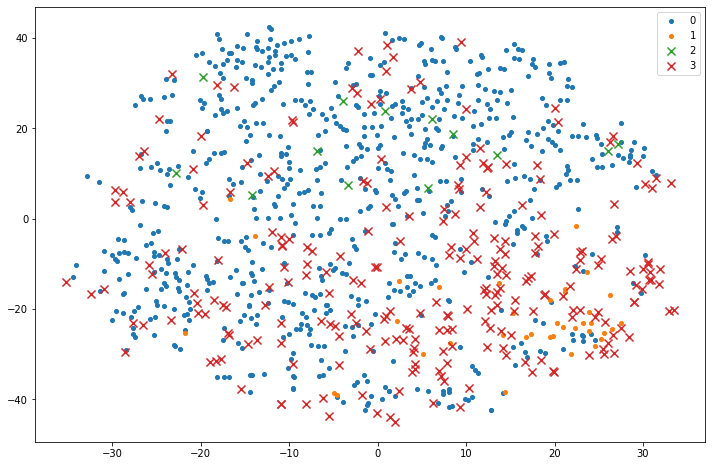

In [82]:
tsne = TSNE(n_jobs=16)
embedded = tsne.fit_transform(out)

vis_x = embedded[:, 0]
vis_y = embedded[:, 1]

fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x[classes == 0], vis_y[classes == 0], cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65, label = '0')
plt.scatter(vis_x[classes == 2], vis_y[classes == 2], cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65, label = '1')
plt.scatter(vis_x[classes == 1], vis_y[classes == 1], cmap=plt.cm.get_cmap("jet", 20), marker='x', s = 65, label = '2')
plt.scatter(vis_x[classes == 3], vis_y[classes == 3], cmap=plt.cm.get_cmap("jet", 20), marker='x', s = 65, label = '3')


#plt.colorbar(ticks=range(10))
# plt.clim(-0.5, 9.5)
plt.legend()
plt.show()


In [83]:
data_iter = iter(train_loader)
feat, out, sen, tar = [], [], [], []

with torch.no_grad():
    for i in range(4):
        pos_1, pos_2, sens, target = data_iter.next()
        pos_1 = pos_1.to(device)
        
        feature_1, out_1_d = model_b(pos_1)

        feat.append(feature_1.detach().cpu())
        out.append(out_1_d.detach().cpu())
        tar.append(target.detach().cpu())
        sen.append(sens)
    
feat = torch.cat(feat)
out = torch.cat(out)
sen = torch.cat(sen)
tar = torch.cat(tar)

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


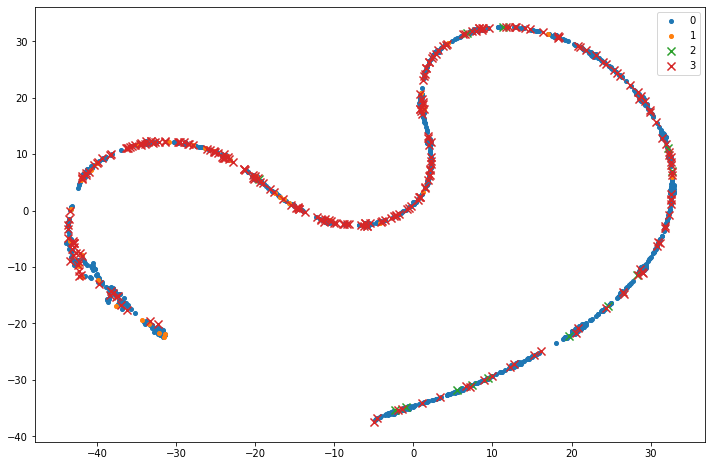

In [84]:
tsne = TSNE(n_jobs=16)
embedded = tsne.fit_transform(out)

vis_x = embedded[:, 0]
vis_y = embedded[:, 1]

fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x[classes == 0], vis_y[classes == 0], cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65, label = '0')
plt.scatter(vis_x[classes == 2], vis_y[classes == 2], cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65, label = '1')
plt.scatter(vis_x[classes == 1], vis_y[classes == 1], cmap=plt.cm.get_cmap("jet", 20), marker='x', s = 65, label = '2')
plt.scatter(vis_x[classes == 3], vis_y[classes == 3], cmap=plt.cm.get_cmap("jet", 20), marker='x', s = 65, label = '3')


#plt.colorbar(ticks=range(10))
# plt.clim(-0.5, 9.5)
plt.legend()
plt.show()


In [41]:
epoch = 0
epochs = 100

In [44]:
total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
feature_labels = []
c = 4
with torch.no_grad():
    # generate feature bank
    for data, _, sens, target in tqdm.tqdm(memory_loader, desc='Feature extracting'):
        feature, out = model_d(data.to(device, non_blocking=True))
        feature_bank.append(feature)
        feature_labels.extend(target * 2 + sens)
    # [D, N]
    feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
    # [N]
    feature_labels = torch.tensor(feature_labels, device=feature_bank.device) 
    # loop test data to predict the label by weighted knn search
    test_bar = tqdm.tqdm(test_loader)
    
    total_correct = np.array([0] * c)
    total_num_class = np.array([0] * c)
    
    
    for data, _, sens, target in test_bar:
        data, sens, target = data.to(device, non_blocking=True), sens.to(device, non_blocking=True), target.to(device, non_blocking=True)
        group = target *2 + sens
        
        feature, out = model_d(data)

        2total_num += data.size(0)
        
        for i in range(c):
            total_num_class[i] += torch.sum((group == i).float()).item()
            
        # compute cos similarity between each feature vector and feature bank ---> [B, N]
        sim_matrix = torch.mm(feature, feature_bank)
        # [B, K]
        sim_weight, sim_indices = sim_matrix.topk(k=k, dim=-1)
        # [B, K]
        sim_labels = torch.gather(feature_labels.expand(data.size(0), -1), dim=-1, index=sim_indices)
        sim_weight = (sim_weight / temperature).exp()

        # [B*K, C]
        one_hot_label = F.one_hot(sim_labels.view(-1, 1).long(), c)
        # weighted score ---> [B, C]
        pred_scores = torch.sum(one_hot_label.view(data.size(0), -1, c) * sim_weight.unsqueeze(dim=-1), dim=1)

        pred_labels = pred_scores.argsort(dim=-1, descending=True)
        total_top1 += torch.sum((pred_labels[:,:1] == target.long().unsqueeze(dim=-1)).any(dim=-1).float()).item()
        
        for i in range(c):
            total_correct[i] += torch.sum((pred_labels[group == i,:1] == target[group == i].long().unsqueeze(dim=-1)).any(dim=-1).float()).item()

        desc = 'KNN Test Epoch: [{}/{}] Acc :{:.2f}%, '\
                    .format(epoch, epochs, total_top1 / total_num * 100)
        
        for i in range(c):
            desc += 'group {} acc : {:.2f}%, '.format(i, (total_correct[i] / total_num_class[i]) * 100)

        test_bar.set_description(desc)

Feature extracting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  5.10it/s]
KNN Test Epoch: [0/100] Acc :75.40%, group 0 acc : 100.00%, group 1 acc : 93.78%, group 2 acc : 0.00%, group 3 acc : 0.00%, : 100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


In [43]:
total_correct

array([78, 92,  0,  0])

In [31]:
one_hot_label = F.one_hot(sim_labels.view(-1, 1).long(), c)

In [34]:
pred_scores = torch.sum(one_hot_label.view(data.size(0), -1, c) * sim_weight.unsqueeze(dim=-1), dim=1)

pred_labels = pred_scores.argsort(dim=-1, descending=True)

In [36]:
total_top1 += torch.sum((pred_labels[:,:1] == target.long().unsqueeze(dim=-1)).any(dim=-1).float()).item()

In [37]:
total_top1

173.0

In [27]:
feature_labels.shape

torch.Size([4795])

In [25]:
one_hot_label.shape

torch.Size([51200, 4])

In [18]:
with torch.no_grad():
    for data, _, sens, target in test_bar:
        data, sens, target = data.to(device, non_blocking=True), sens.to(device, non_blocking=True), target.to(device, non_blocking=True)
        feature, out = model_d(data)

        total_num += data.size(0)
        # compute cos similarity between each feature vector and feature bank ---> [B, N]
        sim_matrix = torch.mm(feature, feature_bank)
        # [B, K]
        sim_weight, sim_indices = sim_matrix.topk(k=k, dim=-1)
        # [B, K]
        sim_labels = torch.gather(feature_labels.expand(data.size(0), -1), dim=-1, index=sim_indices)
        sim_weight = (sim_weight / temperature).exp()

        # counts for each class
        one_hot_label = torch.zeros(data.size(0) * k, c, device=sim_labels.device)
        # [B*K, C]
        one_hot_label = sim_labels.scatter(dim=-1, index=sim_labels.view(-1, 1).long(), value=1.0)
        # weighted score ---> [B, C]
        pred_scores = torch.sum(one_hot_label.view(data.size(0), -1, c) * sim_weight.unsqueeze(dim=-1), dim=1)

        pred_labels = pred_scores.argsort(dim=-1, descending=True)
        total_top1 += torch.sum((pred_labels[:,:1] == target.long().unsqueeze(dim=-1)).any(dim=-1).float()).item()
        total_top5 += torch.sum((pred_labels[:,:5] == target.long().unsqueeze(dim=-1)).any(dim=-1).float()).item()


        desc = 'KNN Test Epoch: [{}/{}] Acc@1:{:.2f}% Acc@5:{:.2f}%'\
                    .format(epoch, epochs, total_top1 / total_num * 100, total_top5 / total_num * 100)

        test_bar.set_description(desc)

  0%|                                                                                                                                                                                                                        | 0/5 [00:28<?, ?it/s]


NameError: name 'feature_labels' is not defined

In [15]:
model_d

DataParallel(
  (module): Classifier(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [37]:
cls = Net(2, model_d).cuda()

In [28]:
cls

Net(
  (f): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [21]:
train_data, _, test_data = utils.get_dataset('cub', '', pair=False)

In [22]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)

In [23]:
train_data[0]

(tensor([[[ 0.5022,  0.5022,  0.4851,  ..., -0.6623, -0.6623, -0.6623],
          [ 0.5193,  0.5022,  0.5022,  ..., -0.6452, -0.6452, -0.6452],
          [ 0.5193,  0.5193,  0.5022,  ..., -0.6452, -0.6452, -0.6452],
          ...,
          [-0.9192, -0.9192, -0.9363,  ..., -0.5082, -0.5596, -0.6452],
          [-0.9705, -0.9534, -0.9534,  ..., -0.7137, -0.7479, -0.8335],
          [-0.9877, -0.9705, -0.9534,  ..., -1.2103, -1.0048, -1.0390]],
 
         [[ 1.0980,  1.0980,  1.0805,  ..., -0.0224, -0.0224, -0.0224],
          [ 1.1155,  1.0980,  1.0980,  ..., -0.0049, -0.0049, -0.0049],
          [ 1.1155,  1.1155,  1.0980,  ..., -0.0049, -0.0049, -0.0049],
          ...,
          [-0.4601, -0.4601, -0.4776,  ..., -1.0903, -1.1779, -1.2304],
          [-0.5126, -0.4951, -0.4951,  ..., -1.0203, -1.1779, -1.2129],
          [-0.5301, -0.5126, -0.4951,  ..., -1.3004, -1.2829, -1.2654]],
 
         [[ 2.1694,  2.1694,  2.1520,  ...,  1.2805,  1.2805,  1.2805],
          [ 2.1868,  2.1694,

In [24]:
train_loader.dataset.sens_groups

array([1, 0])

In [34]:
train_loader

In [38]:
optimizer = optim.Adam(cls.fc.parameters(), lr=1e-3, weight_decay=1e-6)

In [ ]:
loss_criterion = nn.CrossEntropyLoss()

In [41]:
epoch =0

In [ ]:
results['']

In [51]:
results = {'train_loss': [], 'train_acc': [], 'train_acc_group': [], 'train_acc(min)' : [], 'worst_group':[],
           'test_loss': [], 'test_acc': [], 'test_acc_group': [], 'test_acc(min)' : [], 'worst_group(test)':[]}

for epoch in range(1, 5 + 1):
    train_loss, train_acc, train_acc_min, worst_group, group_acc = train_val_binary(cls, train_loader, optimizer)
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['train_acc_group'].append(group_acc)
    results['train_acc(min)'].append(train_acc_min)
    results['worst_group'].append(worst_group)
    if epoch % 5 == 0:
        test_loss, test_acc, test_acc_min, worst_group, group_acc = train_val_binary(cls, test_loader, None)

#             os.makedirs('../results/')
#             try:
#                 results=pickle.load( open(save_dir, "rb" ))
#             except:
#                 results = {'train_loss': [], 'train_acc@1': [], 'train_acc@5': [], 'train_acc(min)' : [],
#                'test_loss': [], 'test_acc@1': [], 'test_acc@5': [], 'test_acc(min)' : []}
#             results[model_path]=test_acc_1
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        results['test_acc_group'].append(group_acc)
        results['test_acc(min)'].append(test_acc_min)
        results['worst_group(test)'].append(worst_group)

Train Epoch: [1/400] Loss: 0.3557 ACC: 86.07% ||group 0 acc : 96.40%, group 1 acc : 46.74%, group 2 acc : 3.57%, group 3 acc : 63.10%, : 100%|█████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.48it/s]
Train Epoch: [2/400] Loss: 0.3448 ACC: 85.84% ||group 0 acc : 96.20%, group 1 acc : 41.85%, group 2 acc : 1.79%, group 3 acc : 63.67%, : 100%|█████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.61it/s]
Train Epoch: [3/400] Loss: 0.3470 ACC: 86.07% ||group 0 acc : 96.31%, group 1 acc : 47.83%, group 2 acc : 1.79%, group 3 acc : 63.29%, : 100%|█████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.67it/s]
Train Epoch: [4/400] Loss: 0.3462 ACC: 86.47% ||group 0 acc : 96.66%, group 1 acc : 48.37%, group 2 acc : 3.57%, group 3 acc : 63.77%, : 100%|█████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.68it/s]
Train Epoch: [5/400] Los

NameError: name 'test_loader' is not defined

In [42]:

train_val_binary(cls, train_loader, optimizer)

Train Epoch: [0/400] Loss: 0.6832 ACC@1: 70.31% ACC@worst: 3.45%, worst group :3                                                                                                                                            | 0/38 [00:00<?, ?it/s]
Train Epoch: [0/400] Loss: 0.6832 ACC@1: 70.31% ACC@worst: 3.45%, worst group :3 3.45%, :   0%|                                            | 0/38 [00:00<?, ?it/s]
Train Epoch: [0/400] Loss: 0.9090 ACC@1: 70.70% ACC@worst: 1.54%, worst group :3 3.45%, :   3%|▉                                   | 1/38 [00:00<00:34,  1.08it/s]
Train Epoch: [0/400] Loss: 0.9941 ACC@1: 71.88% ACC@worst: 1.06%, worst group :3 1.54%, :   3%|▉                                   | 1/38 [00:01<00:34,  1.08it/s]
Train Epoch: [0/400] Loss: 0.9941 ACC@1: 71.88% ACC@worst: 1.06%, worst group :3 1.06%, :   3%|▉                                   | 1/38 [00:01<00:34,  1.08it/s]
Train Epoch: [0/400] Loss: 1.1197 ACC@1: 72.27% ACC@worst: 0.79%, worst group :3 1.06%, :   8%|██▊      

NameError: name 'logger_train' is not defined

In [49]:
class Net(nn.Module):
    def __init__(self, num_class, encoder):
        super(Net, self).__init__()

       # self.f=model.f
        self.f = encoder.module.model
        # classifier
        self.fc = nn.Linear(512, num_class, bias=True)

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.fc(feature)
        return out


# train or test for one epoch
def train_val(net, data_loader, train_optimizer):
    is_train = train_optimizer is not None
    net.train() if is_train else net.eval()

    num_class = len(data_loader.dataset.classes)
    
    total_loss, total_correct_1, total_correct_5, total_num, data_bar = 0.0, 0.0, 0.0, 0, tqdm(data_loader)
    total_correct_min = np.array([0] * num_class)
    total_num_class = np.array([0] * num_class)
    
    with (torch.enable_grad() if is_train else torch.no_grad()):
        for data, target in data_bar:
            data, target = data.to(device,non_blocking=True), target.to(device,non_blocking=True)
            out = net(data)
            loss = loss_criterion(out, target)

            if is_train:
                train_optimizer.zero_grad()
                loss.backward()
                train_optimizer.step()

            total_num += data.size(0)
            total_loss += loss.item() * data.size(0)
            prediction = torch.argsort(out, dim=-1, descending=True)
            total_correct_1 += torch.sum((prediction[:, 0:1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_correct_5 += torch.sum((prediction[:, 0:5] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            
            for i in range(num_class):
                idx = target == i
                total_correct_min[i] += torch.sum((prediction[idx, 0:1] == target[idx].unsqueeze(dim=-1)).any(dim=-1).float()).item()
                total_num_class[i] += sum(idx).item()

            desc = '{} Epoch: [{}/{}] Loss: {:.4f} ACC@1: {:.2f}% ACC@5: {:.2f}%, ACC@worst: {:.2f}%, worst group :{}'\
                                     .format('Train' if is_train else 'Test', epoch, epochs, total_loss / total_num,\
                                             total_correct_1 / total_num * 100, total_correct_5 / total_num * 100,\
                                            min(total_correct_min / total_num_class) * 100, np.argmin(total_correct_min / total_num_class))
                
            data_bar.set_description(desc)

        logger_train.info(desc)
    return total_loss / total_num, total_correct_1 / total_num * 100, total_correct_5 / total_num * 100, min(total_correct_min / total_num_class) * 100, np.argmin(total_correct_min / total_num_class)


def train_val_binary(net, data_loader, train_optimizer):
    is_train = train_optimizer is not None
    net.train() if is_train else net.eval()

    num_class = len(data_loader.dataset.classes)
    num_sens = len(data_loader.dataset.sens_groups)
    num_group = num_sens * num_class
    
    total_loss, total_correct, total_num, data_bar = 0.0, 0.0, 0, tqdm.tqdm(data_loader)
    total_correct_min = np.array([0] * num_group)
    total_num_class = np.array([0] * num_group)
    
    with (torch.enable_grad() if is_train else torch.no_grad()):
        for data, sens, target in data_bar:
            data, sens, target = data.to(device,non_blocking=True), sens.to(device,non_blocking=True), target.to(device,non_blocking=True)
            out = net(data)
            loss = loss_criterion(out, target)

            if is_train:
                train_optimizer.zero_grad()
                loss.backward()
                train_optimizer.step()

            total_num += data.size(0)
            total_loss += loss.item() * data.size(0)
            prediction = torch.argsort(out, dim=-1, descending=True)
            total_correct += torch.sum((prediction[:, 0:1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()

            group = target * 2 + sens
            
            for i in range(num_group):
                idx = group == i
                total_correct_min[i] += torch.sum((prediction[idx, 0:1] == target[idx].unsqueeze(dim=-1)).any(dim=-1).float()).item()
                total_num_class[i] += sum(idx).item()

            desc = '{} Epoch: [{}/{}] Loss: {:.4f} ACC: {:.2f}% ||'\
                         .format('Train' if is_train else 'Test', epoch, epochs, total_loss / total_num,\
                         total_correct / total_num * 100)

            for i in range(num_group):
                desc += 'group {} acc : {:.2f}%, '.format(i, (total_correct_min[i] / total_num_class[i]) * 100)
            
            data_bar.set_description(desc)

#         logger_train.info(desc)
    return total_loss / total_num, total_correct / total_num * 100, min(total_correct_min / total_num_class) * 100, np.argmin(total_correct_min / total_num_class), \
                    [(total_correct_min[i] / total_num_class[i]) * 100 for i in range(num_group)]



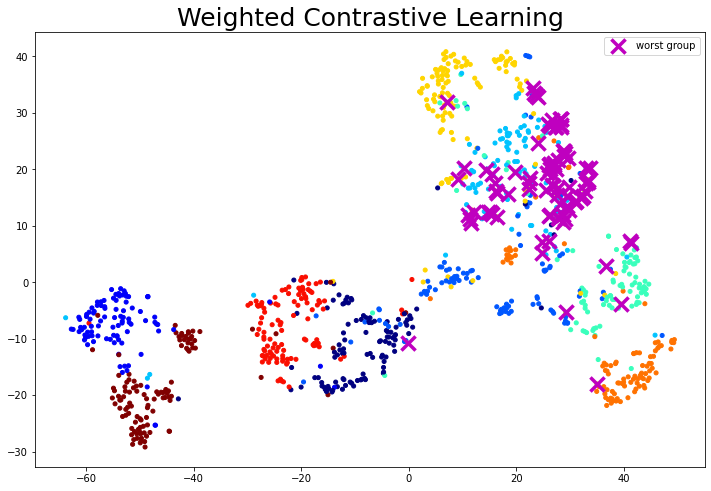

In [68]:
fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x, vis_y, c=tar, cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65)
plt.scatter(vis_x[tar == hard_group], vis_y[tar == hard_group], c = 'm', \
            marker='x', s = 200, lw = 3.5, label = 'worst group')
plt.legend()

# plt.title('Debiased Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/DCL.pdf', bbox_inches='tight')

# plt.title('Hard sample Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/HCL.pdf', bbox_inches='tight')

plt.title('Weighted Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/WCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning ($E_b$)', fontsize = 25n)
# plt.savefig('figures/cifar10/WCL(b).pdf', bbox_inches='tight')

plt.show()


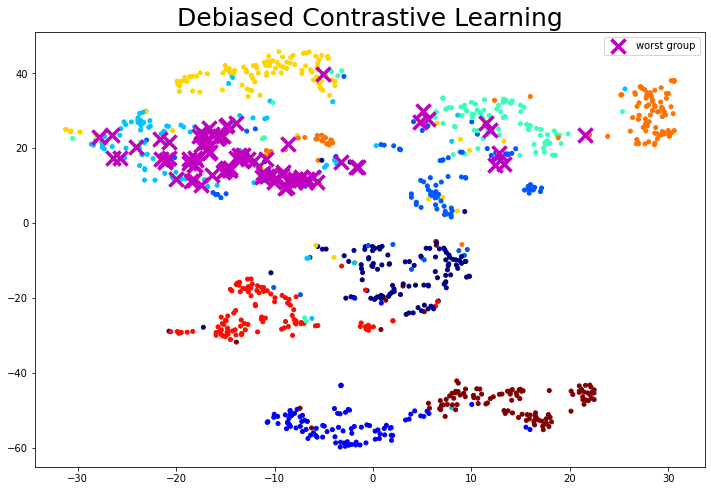

In [76]:
fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x, vis_y, c=tar, cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65)
plt.scatter(vis_x[tar == hard_group], vis_y[tar == hard_group], c = 'm', \
            marker='x', s = 200, lw = 3.5, label = 'worst group')
plt.legend()

plt.title('Debiased Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/DCL.pdf', bbox_inches='tight')

# plt.title('Hard sample Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/HCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/WCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning ($E_b$)', fontsize = 25n)
# plt.savefig('figures/cifar10/WCL(b).pdf', bbox_inches='tight')

plt.show()


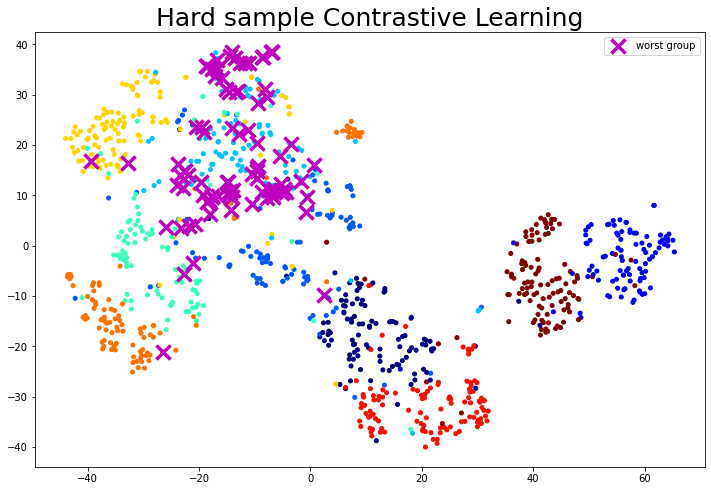

In [72]:
fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x, vis_y, c=tar, cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65)
plt.scatter(vis_x[tar == hard_group], vis_y[tar == hard_group], c = 'm', \
            marker='x', s = 200, lw = 3.5, label = 'worst group')
plt.legend()

# plt.title('Debiased Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/DCL.pdf', bbox_inches='tight')

plt.title('Hard sample Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/HCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/WCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning ($E_b$)', fontsize = 25n)
# plt.savefig('figures/cifar10/WCL(b).pdf', bbox_inches='tight')

plt.show()


In [26]:
import pickle 
pickle.load( open( '../results/summary_dcl.pkl', "rb" ))

{'train_loss': [1.352896473197937,
  0.6573573044776917,
  0.5230751333236694,
  0.4771652105998993,
  0.4564253346824646,
  0.44057649498939516,
  0.4323976421642303,
  0.4248136029911041,
  0.4210838715171814,
  0.41998688117027283,
  0.41457284764289853,
  0.40812781759262085,
  0.41131137600898743,
  0.4096531489086151,
  0.4029350093841553,
  0.4005132156944275,
  0.400172165555954,
  0.3928316573619843,
  0.39728879360198976,
  0.39885678647994993,
  0.39133828516960145,
  0.39839599944114684,
  0.3986996331882477,
  0.3935649960803986,
  0.39344157689094544,
  0.3857441089344025,
  0.39392248525619505,
  0.3861663512229919,
  0.3835730926895142,
  0.38330222647666934],
 'train_acc@1': [81.572,
  84.50999999999999,
  85.184,
  85.596,
  85.802,
  85.938,
  86.09599999999999,
  86.162,
  86.194,
  86.18400000000001,
  86.454,
  86.516,
  86.572,
  86.316,
  86.666,
  86.572,
  86.866,
  87.008,
  86.82600000000001,
  86.72999999999999,
  86.992,
  86.7,
  86.69200000000001,
  86.8